In [1]:
import warnings
warnings.filterwarnings('ignore')

from popsycle import synthetic
from popsycle import utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from params import mock_roman_params
import h5py

%reload_ext autoreload
%autoreload 2

In additional to the usual python/astropy things, you'll need to install Galaxia, PyPopStar, PopSyCLE.
For PyPopStar, it goes faster once you've made isochrones.
Same goes from PopSyCLE with the initial-final cluster mass ratio file.

# Galaxia

This is where you generate the stellar model and set the survey direction and area.


Then create the stellar model, 
by running `galaxia -r galaxia_params.example.txt` on the command line. 
PopSyCLE can also combine these two steps by executing:


In [29]:
synthetic.run_galaxia(output_root = 'ffp',
                      longitude = mock_roman_params['longitude'],
                      latitude = mock_roman_params['latitude'],
                      area = mock_roman_params['area'],
                      galaxia_galaxy_model_filename='galaxyModelParams_Popsycle_roman_docker.txt')

** Generating galaxia_params.ffp.txt **
-- outputFile ffp
-- outputDir ./
-- photoSys UBV
-- magcolorNames V,B-V
-- appMagLimits[0] -1000
-- appMagLimits[1] 1000
-- absMagLimits[0] -1000
-- absMagLimits[1] 1000
-- colorLimits[0] -1000
-- colorLimits[1] 1000
-- geometryOption 1
-- longitude 1.000000
-- latitude -1.030000
-- surveyArea 0.00160
-- fSample 1
-- popID -1
-- warpFlareOn 1
-- seed 91
-- r_max 30
-- starType 0
-- photoError 0
** Executing Galaxia with galaxia_params.ffp.txt and galaxyModelParams_Popsycle_roman_docker.txt **
Galaxia complete
galaxia runtime : 295.483409 s


# Population Synthesis

The stellar model now needs compact objects, which we inject with PopSyCLE. 
This produces an .h5 file with both stars and compact objects, sorted by latitude and longitude.
Here you can set the black hole and neutron star kick speeds.

In [7]:
synthetic.perform_pop_syn(ebf_file = 'ffp.ebf', 
                          output_root = 'generated_files/ffp',
                          iso_dir = '/galaxia_models/GalaxiaData/Isochrones/',
                          bin_edges_number = None, 
                          BH_kick_speed_mean = mock_roman_params['BH_kick_speed_mean'],
                          NS_kick_speed_mean = mock_roman_params['NS_kick_speed_mean'],
                          overwrite=True)

*********************** Starting popid 0
Starting age bin  5.2578840255737305
Starting sub-bin  0
Starting age bin  6.3
Starting sub-bin  0
Starting age bin  7.0
Starting sub-bin  0
Changing to logg=2.50 for T= 11859 logg=2.48
Isochrone generation took 17.533500 s.
Making photometry for isochrone: log(t) = 7.35  AKs = 0.00  dist = 10
     Starting at:  2023-02-14 17:00:47.639657   Usually takes ~5 minutes
Starting filter: ubv,U   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.100 Msun  T =  3010 K  m_ubv_U = 15.23
M =   1.631 Msun  T =  7777 K  m_ubv_U = 2.82
M =   5.493 Msun  T = 17573 K  m_ubv_U = -1.81
M =  10.447 Msun  T = 20313 K  m_ubv_U = -4.75
M =  10.488 Msun  T =  9687 K  m_ubv_U = -5.73
M =  10.512 Msun  T =  3622 K  m_ubv_U = -0.15
M =  11.093 Msun  T =  3598 K  m_ubv_U = -0.16
Starting filter: ubv,B   Elapsed time: 5.26 seconds
Starting synthetic photometry
M =   0.100 Msun  T =  3010 K  m_ubv_B = 14.27
M =   1.631 Msun  T =  7777 K  m_ubv_B = 2.80
M =   

### Add PBHs

In [33]:
#Most of these are default values, but want to show them all for clarity
synthetic.add_pbh('generated_files/ffp.h5', 
                  'generated_files/ffp.ebf', 
                  new_output_root='generated_files/ffp_w_pbh', 
                  pbh_mass=mock_roman_params['pbh_mass'], 
                  fdm=mock_roman_params['fdm'],
                  v_esc = mock_roman_params['v_esc'],
                  rho_0=mock_roman_params['rho_0'],
                  r_s = mock_roman_params['r_s'], 
                  r_max = mock_roman_params['r_max'],
                  gamma=mock_roman_params['gamma'],)

Projected density along line-of-sight = 1.29e+09 [M_sun kpc**-2]
Mass within line-of-sight cylinder = 1.73e+05 [M_sun]
Number of PBH before and after light cone masking: 5769 and 1490, respectively
1490 PBHs in the field
- 0 PBHS removed from generated_files/ffp.h5
--- 754840 original objects
--- 1490 PBHs in the field
--- 756330 new total objects
Binned PBHs equals total PBHs
add_pbh runtime: 18.094440 s


# Finding microlensing events

Here is when all microlensing events are found.
You can set the survey duration, cadence, maximum impact parameter, blend radius.
This also has the option of being parallelizable.

In [34]:
#Set to Roman Params from paper
synthetic.calc_events(hdf5_file = 'generated_files/ffp_w_pbh.h5', 
                      output_root2 = 'generated_files/ffp_w_pbh', 
                      radius_cut = 2,
                      obs_time = mock_roman_params["obs_time"], 
                      n_obs = int(mock_roman_params["obs_time"]/mock_roman_params["cadence"]), 
                      theta_frac = 2, 
                      blend_rad = mock_roman_params["blend_rad"], 
                      overwrite = False, 
                      n_proc = 7,) #adjust based on your number of cores

Working on loop ll, bb =  0 0
Candidate events detected:  17
calc_events runtime : 56.583784 s


# Photometry

This is the last thing, where you choose the photometric band for the observations and the reddening law.
The final file of microlensing events is produced here as a .fits file.

In [35]:
synthetic.refine_events(input_root = 'generated_files/ffp_w_pbh', 
                        filter_name = 'I',
                        photometric_system = 'ubv',
                        red_law = 'Damineli16', 
                        overwrite = False, 
                        output_file = 'default')

Original candidate events:  14
Candidate events in survey window:  1
refine_events runtime : 0.214253 s


# Things you can do with PopSyCLE

First, read in the table, and print out a list of all the possible keys:

In [37]:
# t = Table.read('example_refined_events_i_Damineli16.fits')
t = Table.read('generated_files/ffp_w_pbh_refined_events_ubv_I_Damineli16.fits')

print(t.colnames)

['zams_mass_L', 'mass_L', 'px_L', 'py_L', 'pz_L', 'vx_L', 'vy_L', 'vz_L', 'age_L', 'popid_L', 'exbv_L', 'glat_L', 'glon_L', 'mbol_L', 'grav_L', 'teff_L', 'feh_L', 'rad_L', 'rem_id_L', 'obj_id_L', 'ubv_J_L', 'ubv_H_L', 'ubv_K_L', 'ubv_U_L', 'ubv_I_L', 'ubv_B_L', 'ubv_V_L', 'ubv_R_L', 'vr_L', 'mu_b_L', 'mu_lcosb_L', 'zams_mass_S', 'mass_S', 'px_S', 'py_S', 'pz_S', 'vx_S', 'vy_S', 'vz_S', 'age_S', 'popid_S', 'exbv_S', 'glat_S', 'glon_S', 'mbol_S', 'grav_S', 'teff_S', 'feh_S', 'rad_S', 'rem_id_S', 'obj_id_S', 'ubv_J_S', 'ubv_H_S', 'ubv_K_S', 'ubv_U_S', 'ubv_I_S', 'ubv_B_S', 'ubv_V_S', 'ubv_R_S', 'vr_S', 'mu_b_S', 'mu_lcosb_S', 'theta_E', 'u0', 'mu_rel', 't0', 't_E', 'ubv_I_app_S', 'ubv_I_app_L', 'cent_glon_I_N', 'cent_glat_I_N', 'ubv_I_app_N', 'ubv_I_app_LSN', 'delta_m_I', 'f_blend_I', 'pi_rel', 'pi_E']


## Figure out how many events due to BH, NS, WD, star

In [38]:
pbh_idx = np.where(t['rem_id_L'] == 104)[0]
bh_idx = np.where(t['rem_id_L'] == 103)[0]
ns_idx = np.where(t['rem_id_L'] == 102)[0]
wd_idx = np.where(t['rem_id_L'] == 101)[0]
st_idx = np.where(t['rem_id_L'] == 0)[0]
print('Number of PBHs: ' + str(len(pbh_idx)))
print('Number of BHs: ' + str(len(bh_idx)))
print('Number of NSs: ' + str(len(ns_idx)))
print('Number of WDs: ' + str(len(wd_idx)))
print('Number of stars: ' + str(len(st_idx)))

Number of PBHs: 0
Number of BHs: 0
Number of NSs: 0
Number of WDs: 0
Number of stars: 1


## Histogram of tE

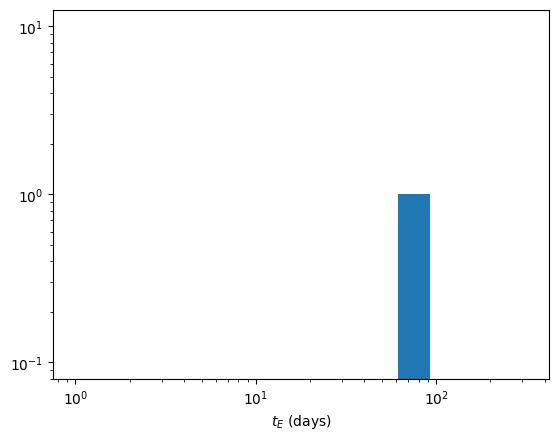

In [39]:
plt.hist(t['t_E'], bins = np.logspace(0, 2.5, 15))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.show()

## piE vs tE

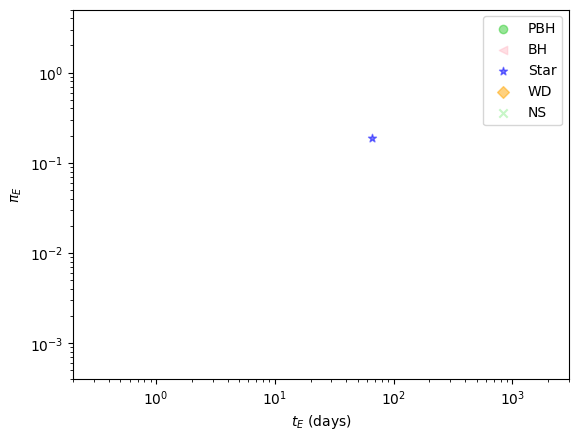

In [40]:
plt.scatter(t['t_E'][pbh_idx], t['pi_E'][pbh_idx], color = 'limegreen', marker='o', label = 'PBH', alpha=0.5)
plt.scatter(t['t_E'][bh_idx], t['pi_E'][bh_idx], color = 'pink', marker='<', label = 'BH', alpha=0.5)
plt.scatter(t['t_E'][st_idx], t['pi_E'][st_idx], color = 'blue', marker='*', label = 'Star', alpha=0.5)
plt.scatter(t['t_E'][wd_idx], t['pi_E'][wd_idx], color = 'orange', marker='D', label = 'WD', alpha=0.5)
plt.scatter(t['t_E'][ns_idx], t['pi_E'][ns_idx], color = 'lightgreen', marker='x', label = 'NS', alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.ylabel('$\pi_E$')
plt.xlim(2e-1, 3e3)
plt.ylim(4e-4, 5e0)
plt.legend()
plt.show()

## dL vs dS

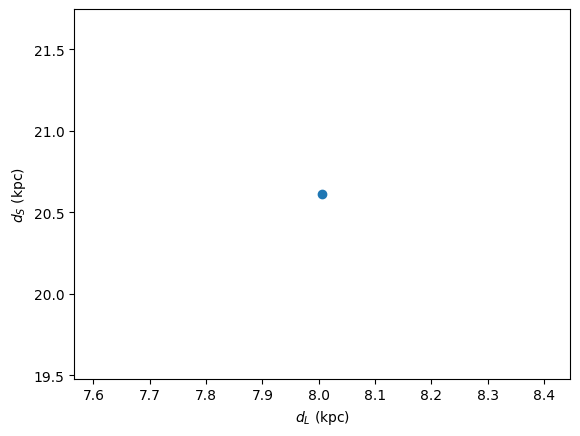

In [41]:
plt.scatter(t['rad_L'], t['rad_S'])
plt.xlabel('$d_L$ (kpc)')
plt.ylabel('$d_S$ (kpc)')
plt.show()